# Data Scientist Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Python 3.0

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

In [107]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score,fbeta_score
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
import visuals as vs
import warnings


----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [108]:
# Import libraries necessary for this project

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


##### Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.


In [109]:
cols = ['workclass','education_level','marital-status','occupation','relationship','race','sex','native-country']
for col in cols:
    print(col,'\n', data[col].value_counts(), '\n')

workclass 
  Private             33307
 Self-emp-not-inc     3796
 Local-gov            3100
 State-gov            1946
 Self-emp-inc         1646
 Federal-gov          1406
 Without-pay            21
Name: workclass, dtype: int64 

education_level 
  HS-grad         14783
 Some-college     9899
 Bachelors        7570
 Masters          2514
 Assoc-voc        1959
 11th             1619
 Assoc-acdm       1507
 10th             1223
 7th-8th           823
 Prof-school       785
 9th               676
 12th              577
 Doctorate         544
 5th-6th           449
 1st-4th           222
 Preschool          72
Name: education_level, dtype: int64 

marital-status 
  Married-civ-spouse       21055
 Never-married            14598
 Divorced                  6297
 Separated                 1411
 Widowed                   1277
 Married-spouse-absent      552
 Married-AF-spouse           32
Name: marital-status, dtype: int64 

occupation 
  Craft-repair         6020
 Prof-specialty       600

In [110]:
data.income.value_counts()

<=50K    34014
>50K     11208
Name: income, dtype: int64

In [111]:
n_records = data.shape[0]
n_greater_50k = data[data['income'] == ">50K"].shape[0]
n_at_most_50k = data[data['income'] == "<=50K"].shape[0]

greater_percent = n_greater_50k / n_records *100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [112]:
data.sample()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
4344,55,Private,Bachelors,13.0,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

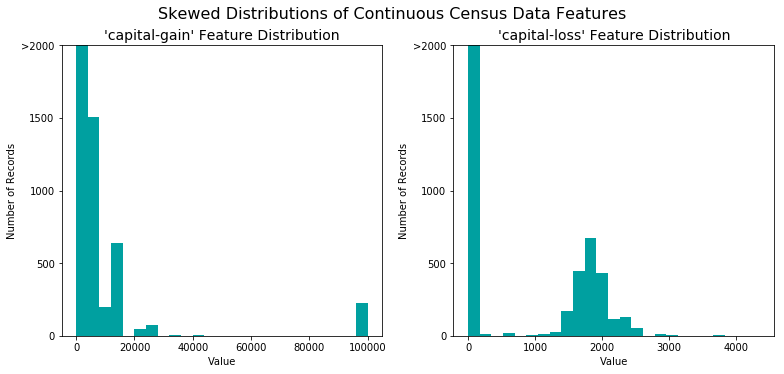

In [113]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

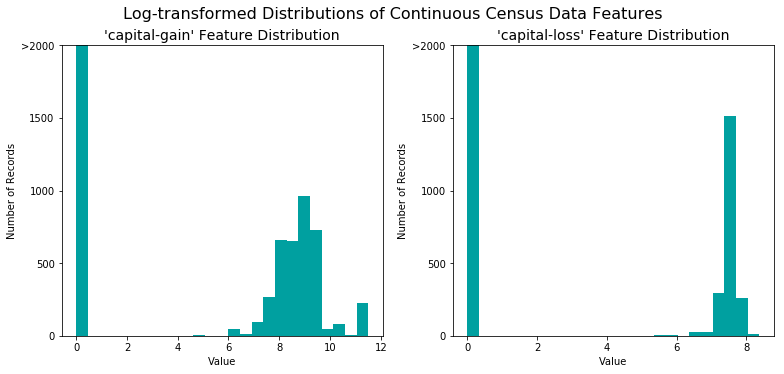

In [114]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [9]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [10]:
income_raw.value_counts()

<=50K    34014
>50K     11208
Name: income, dtype: int64

In [11]:
features_final = pd.get_dummies(features_log_minmax_transform)
income = income_raw.apply(lambda x: 0 if x == "<=50K" else 1)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
#print(encoded)
print(income.value_counts())
print(income_raw.value_counts())


103 total features after one-hot encoding.
0    34014
1    11208
Name: income, dtype: int64
<=50K    34014
>50K     11208
Name: income, dtype: int64


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [12]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


C:\Users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
y_test[:10]

41387    0
35278    0
26950    0
29133    0
41794    0
39744    1
32755    0
6016     1
43034    0
12446    0
Name: income, dtype: int64

----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [14]:
aa = []
for i in range(0,len(y_test)):
    aa.append(1)
len(aa)

9045

In [15]:
all_1 = [1] * len(y_test)
len(all_1)

9045

In [16]:
test_metrics = pd.DataFrame()
test_metrics['y_true'] = y_test
test_metrics['y_pred'] = all_1
test_metrics[:5]

,y_true,y_pred
41387,0,1
35278,0,1
26950,0,1
29133,0,1
41794,0,1


In [17]:
true_positives = len(test_metrics[test_metrics['y_true']==test_metrics['y_pred']])
false_positives = len(test_metrics[(test_metrics['y_pred'] == 1)&(test_metrics['y_true'] == 0)])
false_negatives = len(test_metrics[(test_metrics['y_pred']==0) & (test_metrics['y_true']==1)])

accuracy = true_positives / len(y_test)
recall = true_positives / (true_positives + false_negatives)
precision =  true_positives / (true_positives + false_positives)
print('accuracy:{} \n recall:{} \n precision:{}'.format(accuracy, recall, precision))

accuracy:0.24378109452736318 
 recall:1.0 
 precision:0.24378109452736318


In [18]:
accuracy = len(test_metrics[test_metrics['y_true']==test_metrics['y_pred']]) / test_metrics.shape[0]
accuracy

0.24378109452736318

In [19]:
recall = 

SyntaxError: invalid syntax (<ipython-input-19-82a077385003>, line 1)

In [20]:
accuracy = accuracy_score(y_test,all_1)
accuracy
recall = recall_score(y_test,all_1)
recall
precision = precision_score(y_test,all_1)
f_score = f1_score(y_test,all_1)
print('accuracy:{} \n recall:{} \n precision:{} \n f_score:{}'.format(accuracy, recall, precision,f_score))

accuracy:0.24378109452736318 
 recall:1.0 
 precision:0.24378109452736318 
 f_score:0.392


In [21]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
accuracy = accuracy_score(y_test,all_1)
recall = recall_score(y_test,all_1)
precision = precision_score(y_test,all_1)

beta = 0.5
fscore = (1+beta**2) * (precision*recall) / (beta**2 * precision + recall )

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2438, F-score: 0.2872]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.



**Answer: **

KNN: K-nearest neighbors
KNN predicts the category of a new observation based on how similar that observation is to similar observations it has seen before. For example, if all your 'neighbors' i.e. people with similar characteristcs, earn >50k USD / year, then KNN will likely predict that you also earn >50 kUSD / year. 

This model can be applied whenever you neeed to predict labels or categories of new observations and you have much past data of observations with similar characteristics. 
The

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [48]:
learner = tree.DecisionTreeClassifier()
learner.fit(X_train,y_train)
y_pred = learner.predict(X_test)
accuracy_score(y_test,y_pred)

0.8173576561636263

In [23]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    #Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    #Calculate the training time
    results['train_time'] = end - start
        
    #Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    #Calculate the total prediction time
    results['pred_time'] = end - start
            
    #Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    #Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    #Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,0.5)
        
    #Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    print("Accuracy: {}, F-score: {}".format(results['acc_test'],results['f_test']))
        
    # Return the results
    return results

In [49]:
train_predict(tree.DecisionTreeClassifier(),300,X_train,y_train,X_test,y_test)

DecisionTreeClassifier trained on 300 samples.
Accuracy: 0.7597567716970702, F-score: 0.5163612017742071


{'train_time': 0.004009246826171875,
 'pred_time': 0.016043663024902344,
 'acc_train': 1.0,
 'acc_test': 0.7597567716970702,
 'f_train': 1.0,
 'f_test': 0.5163612017742071}

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

In [27]:
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

In [129]:
from sklearn.ensemble import RandomForestClassifier

In [130]:
train_predict(RandomForestClassifier(),len(X_train),X_train,y_train,X_test,y_test)

RandomForestClassifier trained on 36177 samples.
Accuracy: 0.8364842454394693, F-score: 0.6691243308756691


{'train_time': 0.9745898246765137,
 'pred_time': 0.07118773460388184,
 'acc_train': 0.97,
 'acc_test': 0.8364842454394693,
 'f_train': 0.9638554216867471,
 'f_test': 0.6691243308756691}

In [28]:
train_predict(tree.DecisionTreeClassifier(), len(X_train),X_train,y_train,X_test,y_test)

DecisionTreeClassifier trained on 36177 samples.
Accuracy: 0.8176893311221669, F-score: 0.6261031119368323


{'train_time': 0.9404988288879395,
 'pred_time': 0.02005171775817871,
 'acc_train': 0.97,
 'acc_test': 0.8176893311221669,
 'f_train': 0.9638554216867471,
 'f_test': 0.6261031119368323}

In [29]:
train_predict(GaussianNB(), len(X_train),X_train,y_train,X_test,y_test)

GaussianNB trained on 36177 samples.
Accuracy: 0.5976782752902156, F-score: 0.4208989595756056


{'train_time': 0.277738094329834,
 'pred_time': 0.0762019157409668,
 'acc_train': 0.5933333333333334,
 'acc_test': 0.5976782752902156,
 'f_train': 0.4125,
 'f_test': 0.4208989595756056}

In [30]:
train_predict(svm.SVC(), len(X_train),X_train,y_train,X_test,y_test)

SVC trained on 36177 samples.
Accuracy: 0.8371475953565506, F-score: 0.6744771706996605


{'train_time': 160.80139780044556,
 'pred_time': 23.6922709941864,
 'acc_train': 0.8533333333333334,
 'acc_test': 0.8371475953565506,
 'f_train': 0.7196969696969697,
 'f_test': 0.6744771706996605}

In [131]:
#Import the three supervised learning models from sklearn
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

#Initialize the three models
clf_A = tree.DecisionTreeClassifier()
clf_B = GaussianNB()
clf_C = RandomForestClassifier()

#Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(X_train)
samples_10 = int(len(X_train) * 0.1)
samples_1 = int(len(X_train) * 0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)



DecisionTreeClassifier trained on 361 samples.
Accuracy: 0.7516860143725815, F-score: 0.504985004458134
DecisionTreeClassifier trained on 3617 samples.
Accuracy: 0.802653399668325, F-score: 0.5958825095394445
DecisionTreeClassifier trained on 36177 samples.
Accuracy: 0.8206744057490326, F-score: 0.6323706936577213
GaussianNB trained on 361 samples.
Accuracy: 0.3517965726920951, F-score: 0.3101343466682625
GaussianNB trained on 3617 samples.
Accuracy: 0.3660585959093422, F-score: 0.32025811848355396
GaussianNB trained on 36177 samples.
Accuracy: 0.5976782752902156, F-score: 0.4208989595756056
RandomForestClassifier trained on 361 samples.
Accuracy: 0.8081813156440022, F-score: 0.6025428413488114
RandomForestClassifier trained on 3617 samples.
Accuracy: 0.8302929795467109, F-score: 0.6580853672127495
RandomForestClassifier trained on 36177 samples.
Accuracy: 0.8353786622443339, F-score: 0.6662328561417559


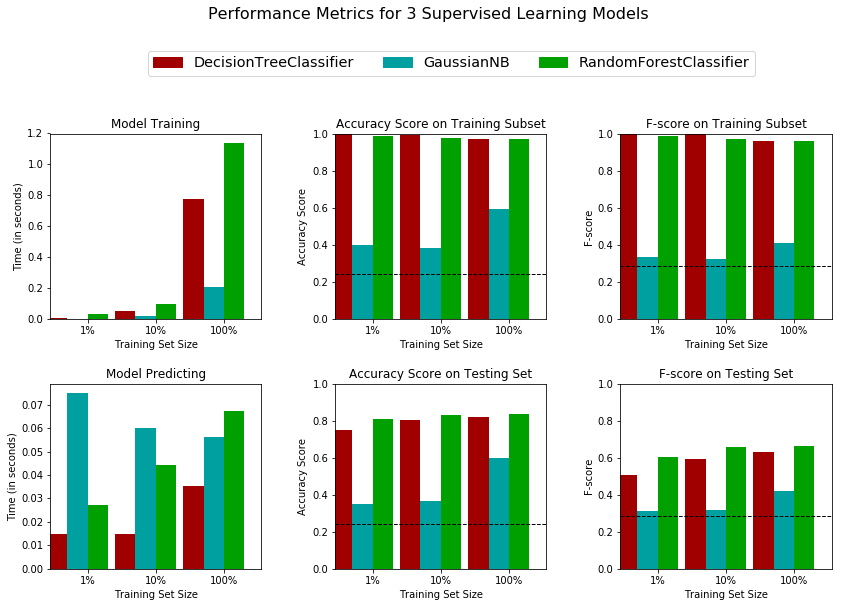

In [132]:
# Run metrics visualization for the three supervised learning models chosen
import visuals_adj as vs_adj
vs_adj.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model


**Best Model: **

To decide on the best model, we should look mainly at the F-Score on the testing set. This perspective gives us two main contendents: The Random Forest Classifier or the decision tree classifier. Although the Decision Tree Classifier performs slightly faster, the Random Forest Classifier offers a better overall prediction as measured by the F-Score. 

Therefore, I choose the RandomForestClassifier as the best model. It is no surprise that the RandomForest performed better than the decision tree, as the random forest is based (and could be considered an improvement) on the Decision Tree.

### Question 4 - Describing the Model in Layman's Terms


According to [Wikipedia](https://en.wikipedia.org/wiki/Random_forest), "a Random Forest  are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification)"

This basically means that the Random Forest Classifier will run several decision trees classifiers and take the most common answer. A decision tree classifier is an algorithm that makes decision trees (see [example of decision tree](https://hackernoon.com/what-is-a-decision-tree-in-machine-learning-15ce51dc445d))

### Implementation: Model Tuning

In [133]:
clf_A = RandomForestClassifier(min_samples_leaf = 20)
train_predict(clf_A, len(X_train),X_train,y_train,X_test,y_test)

RandomForestClassifier trained on 36177 samples.
Accuracy: 0.8525152017689331, F-score: 0.7170832853357907


{'train_time': 0.6177208423614502,
 'pred_time': 0.04004502296447754,
 'acc_train': 0.8533333333333334,
 'acc_test': 0.8525152017689331,
 'f_train': 0.7258064516129031,
 'f_test': 0.7170832853357907}

In [134]:
clf_A = RandomForestClassifier()
parameters = {'max_depth' : [2,6,10,15,20], 'min_samples_split' : [2,5,10,20], 'min_samples_leaf': [2,5,10,20]}
scorer = make_scorer(fbeta_score, beta=0.5)
grid_obj = GridSearchCV(clf_A, parameters, scoring = scorer)

In [135]:
grid_fit = grid_obj.fit(X_train,y_train)

C:\Users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [136]:
best_clf = grid_fit.best_estimator_

In [137]:
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [138]:
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)


In [139]:
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("Precision: {:.1f}% of individuals classified as earning >50k make >50k".format(precision_score(y_test,predictions)*100))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("Precision: {:.1f}% of individuals classified as earning >50k make >50k".format(precision_score(y_test,best_predictions)*100))

Unoptimized model
------
Accuracy score on testing data: 0.8396
F-score on testing data: 0.6758
Precision: 69.4% of individuals classified as earning >50k make >50k

Optimized Model
------
Final accuracy score on the testing data: 0.8557
Final F-score on the testing data: 0.7241
Precision: 77.3% of individuals classified as earning >50k make >50k


In [140]:
#Import 'GridSearchCV', 'make_scorer', and any other necessary libraries

#Initialize the classifier
clf = RandomForestClassifier()

#Create the parameters list you wish to tune, using a dictionary if needed.
clf_A = RandomForestClassifier()
parameters = {'max_depth' : [2,6,10,15,20], 'min_samples_split' : [2,5,10,20], 'min_samples_leaf': [2,5,10,20]}
scorer = make_scorer(fbeta_score, beta=0.5)
grid_obj = GridSearchCV(clf_A, parameters, scoring = scorer)

#Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)
# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

C:\Users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rosaslor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

Unoptimized model
------
Accuracy score on testing data: 0.8392
F-score on testing data: 0.6750

Optimized Model
------
Final accuracy score on the testing data: 0.8583
Final F-score on the testing data: 0.7273


### Question 5 - Final Model Evaluation

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |     0.8396        |      0.8557     |
| F-score        |     0.6758        |      0.7241     |



**Answer: **

After optimizing the model, we improved accuracy by only 1%  and the F-score by 5 percentage points (7%)
This fares much better than our naive predictor, which had an accuracy of 24% and f_score of 0.392


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

Without doing any quantitative analysis, I believe these 5 features to be the best predictors.
Here I will explain which 5 features I took and the reason: 

- capital-gain: We could assume those with larger capital gains to also have a larger income
- Age: Salary and income tend to increase with experience, for which age is a great proxy
- education: It is well known that people with higher education tend to earn more 
- occupation: Some careers pay better than others
- race: minority groups tend to be disadvantaged and face more challenges when climbing the career ladder


### Implementation - Extracting Feature Importance

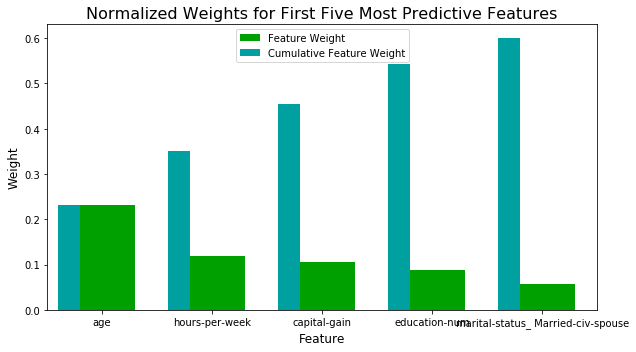

In [144]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train,y_train)
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Interesting! Capital gain, age, and education seemed to be good predictors as I imagined

I was also surprised by hours-per-week. Intuitively, I know that the more hours one works, the more one earns. Howevever, since I though that people employed in jobs with few hours per week would tend to be on the lower-paying end of the spectrum, the job type or education would have  been stronger predictors. Seein this diagram, I imagine that hours per week can be a great predictor precisely because of that reason (that few hours-per-week jobs tend to pay less). 

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [145]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8583
F-score on testing data: 0.7273

Final Model trained on reduced data
------
Accuracy on testing data: 0.8462
F-score on testing data: 0.6951


### Question 8 - Effects of Feature Selection


By applying only 5 features instead of the 13 original features, our model was faster. However, it came at the price of reduced performance. Particularly on our most important metric (F-score). When comparing the new model with our previous optimized model, we see that the F-Score was reduced by 2 percentage points . In practice, this would mean that our charity will be less effective at contacting likely donors. 

In this case, I do not think that training time is a very important factor, as contacting donors is not a decision that eeds to be made in a split second. If it were a different scenario, where a decision is indeed indeed in a verys hort time then it would be worth considering if the reduction in processing time is worth the reduction in performance of the model

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.